In [1]:
# de python, para especificar rutas de archivos y directorios
from pathlib import Path

# lib para trabajar con arrays
import numpy as np
import pandas as pd

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt

# libs que usamos para construir y entrenar redes neuronales, y que además tiene utilidades para leer sets de 
# imágenes
from keras.preprocessing import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import load_img, img_to_array

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

# ANÁLISIS EXPLORATORIO SOBRE EL CONJUNTO DE DATOS

## Estructura y tipo de las imagenes

Nombre imagen: dog.376.jpg
Dimensiones de la imagen:
(375, 499, 3)


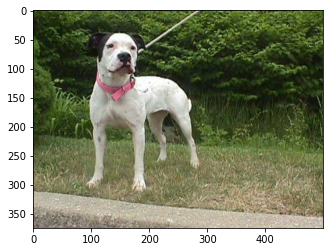

Nombre imagen: cat.159.jpg
Dimensiones de la imagen:
(445, 499, 3)


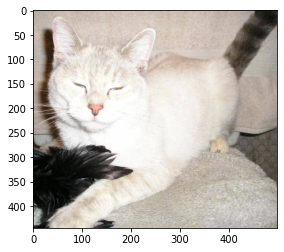

Nombre imagen: dog.2212.jpg
Dimensiones de la imagen:
(360, 479, 3)


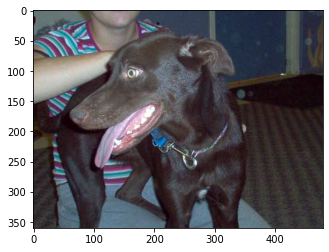

Nombre imagen: cat.2020.jpg
Dimensiones de la imagen:
(393, 499, 3)


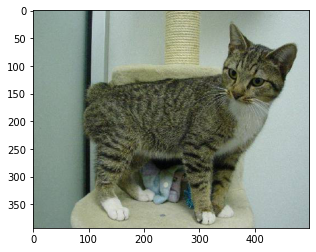

Nombre imagen: dog.69.jpg
Dimensiones de la imagen:
(95, 128, 3)


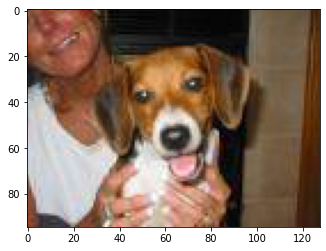

Nombre imagen: cat.836.jpg
Dimensiones de la imagen:
(446, 440, 3)


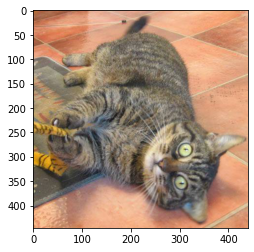

In [2]:
from skimage import io
from random import randint

for x in range(3):
    
    nro_imagen_dog = randint(0,4000)
    nro_imagen_cat = randint(0,4000)
    image_dog=io.imread("./imagenes_tp3_cv/training_set/training_set/dogs/dog.{}.jpg".format(nro_imagen_dog))
    image_cat=io.imread("./imagenes_tp3_cv/training_set/training_set/cats/cat.{}.jpg".format(nro_imagen_cat))

    print("Nombre imagen: dog."+ str(nro_imagen_dog) + ".jpg")
    print("Dimensiones de la imagen:")
    print(image_dog.shape)
    plt.imshow(image_dog)
    plt.show()
    
    print("Nombre imagen: cat."+ str(nro_imagen_cat) + ".jpg")
    print("Dimensiones de la imagen:")
    print(image_cat.shape)
    plt.imshow(image_cat)
    
    plt.show()

## Volumetría de datos

In [3]:
animales = "cats", "dogs"

# Directorio de imágenes
TRAIN_DIR = Path('./imagenes_tp3_cv/training_set/training_set')
TEST_DIR = Path('./imagenes_tp3_cv/test_set/test_set')

In [15]:
train = image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",  # adivinar los labels en base al nombre del sub directorio
    label_mode="categorical",  # tenemos N labels, queremos tuplas de 0s y 1s indicando cuál de los labels es
    class_names=animales,  # para usar el mismo orden en todos lados
    color_mode="rgb",  # queremos trabajar con las imágenes a color
    image_size=(64, 64),  # para que corra más rápido, vamos a achicar las imágenes
    shuffle=True,  # que recorra el set de imágenes en orden aleatorio
    seed=47,  # semilla para que la aleatoriedad sea repetible
)

Found 8005 files belonging to 2 classes.


In [16]:
test = image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="categorical",
    class_names=animales,
    color_mode="rgb",
    image_size=(64, 64),
    shuffle=True,
    seed=47,
)

Found 2023 files belonging to 2 classes.


In [174]:
def sample_images(dataset):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(animales[np.argmax(labels[i])])
            plt.axis("off")

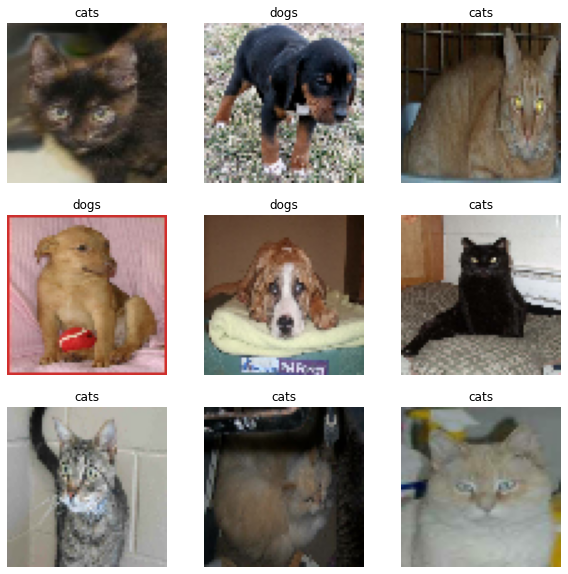

In [175]:
sample_images(train)

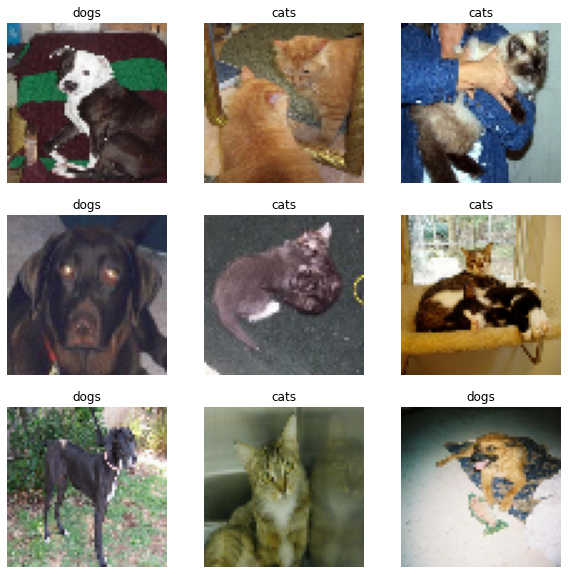

In [176]:
sample_images(test)

## Distribución de la variable a predecir

# MACHINE LEARNING

## Funciones útiles

In [136]:
# Función para predecir

from IPython.display import Image, display

def show_and_predict(model,image_path):
    image_array = img_to_array(load_img(image_path, target_size=(64, 64)))
    inputs = np.array([image_array])  # armamos un "dataset" con solo esa imagen
    predictions = model.predict(inputs)
    display(Image(image_path, width=300))
    print("Prediction:", animales[np.argmax(predictions)])
    print("Prediction detail:", predictions)

In [58]:
# Función que dibuja la matriz de confusión
def matriz(model):
    
    datasets = (
        ("train", train),
        ("test", test),   
    )

    for dataset_name, dataset in datasets:
        print('#' * 25, dataset_name, '#' * 25)

        # el dataset se itera en batches, así que calculamos predicciones y labels por cada batch, y luego 
        # concatenamos todo
        batches_predictions = []
        batches_labels =  []

        for batch_images, batch_labels in dataset:
            # super importante: usamos argmax para convertir cosas de este formato:
            # [(0, 1, 0), (1, 0, 0), (1, 0, 0), (0, 0, 1)]
            # a este formato (donde tenemos el índice de la clase que tiene número más alto):
            # [1, 0, 0, 2]
            batches_predictions.append(np.argmax(model.predict(batch_images), axis=-1))
            batches_labels.append(np.argmax(batch_labels, axis=-1))

        predictions = np.concatenate(batches_predictions)
        labels = np.concatenate(batches_labels)

        print('accuracy', accuracy_score(labels, predictions))

        # graficamos la confussion matrix
        plt.figure(figsize=(3, 4))

        plt.xticks([0, 1], animales, rotation=45)
        plt.yticks([0, 1], animales)
        plt.xlabel('Predicted class')
        plt.ylabel('True class')

        plt.imshow(
            confusion_matrix(labels, predictions), 
            cmap=plt.cm.Blues,
            interpolation='nearest',
        )

        plt.show()

In [59]:
# Función que dibuja las curvas
def curvas(history):
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('Accuracy over train epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

In [81]:
# Función para mostrar ejemplos de predicciones

from skimage import io
from random import randint

def predecir (cantidad,model):
    
    for x in range(cantidad):
    
        nro_imagen_dog = randint(0,4000)
        nro_imagen_cat = randint(0,4000)
        image_dog=io.imread("./imagenes_tp3_cv/training_set/training_set/dogs/dog.{}.jpg".format(nro_imagen_dog))
        image_cat=io.imread("./imagenes_tp3_cv/training_set/training_set/cats/cat.{}.jpg".format(nro_imagen_cat))

        print("Nombre imagen: dog."+ str(nro_imagen_dog) + ".jpg")
        #print("Predicción:")
        show_and_predict(model,"./imagenes_tp3_cv/training_set/training_set/dogs/dog.{}.jpg".format(nro_imagen_dog))
        # plt.imshow(image_dog)
        # plt.show()
        
        print ()
        print ()
        
        print("Nombre imagen: cat."+ str(nro_imagen_cat) + ".jpg")
        #print("Predicción:")
        show_and_predict(model,"./imagenes_tp3_cv/training_set/training_set/cats/cat.{}.jpg".format(nro_imagen_cat))
        # plt.imshow(image_cat)
    
        # plt.show()
        print ()
        print ()

## Modelos

### MLP 1

In [49]:
# 9 capas densas con 20 neuronas
# Función de activación: Relu
    
model_mlp_1 = Sequential([
    
    Rescaling(1/255, input_shape=(64, 64, 3)), # normalizar las entradas de los datasets
  
    Dense(20, activation='relu'),
    Dropout(0.4),
    
    Flatten(),
    
    Dense(20, activation='relu'),
    Dropout(0.1),
    
    Dense(20, activation='relu'),

    Dense(20, activation='relu'),
    Dropout(0.2),
    
    Dense(20, activation='relu'),
    
    Dense(20, activation='relu'),
    Dropout(0.1),
    
    Dense(20, activation='relu'),
    
    Dense(20, activation='relu'),
    Dropout(0.2),
    
    Dense(len(animales), activation='softmax'),
    # salida de 2
])

model_mlp_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [50]:
model_mlp_1.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_8 (Rescaling)      (None, 64, 64, 3)         0         
_________________________________________________________________
dense_83 (Dense)             (None, 64, 64, 20)        80        
_________________________________________________________________
dropout_41 (Dropout)         (None, 64, 64, 20)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 81920)             0         
_________________________________________________________________
dense_84 (Dense)             (None, 20)                1638420   
_________________________________________________________________
dropout_42 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_85 (Dense)             (None, 20)               

In [51]:
history_mlp_1 = model_mlp_1.fit(
    train,
    epochs=10,
    batch_size=50, # Ajusta los pesos cada x imagenes
    validation_data=test,
)

Epoch 1/10
251/251 [==============================] - 47s 178ms/step - loss: 0.7068 - accuracy: 0.4991 - val_loss: 0.6932 - val_accuracy: 0.5072
Epoch 2/10
251/251 [==============================] - 42s 166ms/step - loss: 0.6936 - accuracy: 0.5024 - val_loss: 0.6927 - val_accuracy: 0.5091
Epoch 3/10
251/251 [==============================] - 42s 165ms/step - loss: 0.6918 - accuracy: 0.5036 - val_loss: 0.6754 - val_accuracy: 0.5606
Epoch 4/10
251/251 [==============================] - 42s 167ms/step - loss: 0.6703 - accuracy: 0.5767 - val_loss: 0.6518 - val_accuracy: 0.6411
Epoch 5/10
251/251 [==============================] - 43s 171ms/step - loss: 0.6492 - accuracy: 0.6254 - val_loss: 0.6415 - val_accuracy: 0.6480
Epoch 6/10
251/251 [==============================] - 48s 189ms/step - loss: 0.6412 - accuracy: 0.6310 - val_loss: 0.6401 - val_accuracy: 0.6476
Epoch 7/10
251/251 [==============================] - 64s 254ms/step - loss: 0.6329 - accuracy: 0.6522 - val_loss: 0.6360 - val_ac

######################### train #########################
accuracy 0.7071830106183635


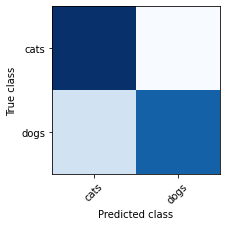

######################### test #########################
accuracy 0.6707859614434009


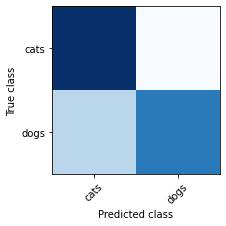

In [52]:
matriz(model_mlp_1)

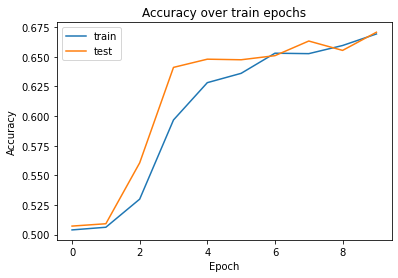

In [53]:
curvas(history_mlp_1)

## Conclusión MLP 1
Para el primer modelo MLP que construimos podemos observar que obtuvimos un **70 %** de accuracy en **train** y un **67 %** en **test**.
Además, observando la matriz de confusión podemos concluir que la **mayor cantidad de predicciones acertadas** es en la clase **gatos**.

Algunas predicciones:

Nombre imagen: dog.415.jpg


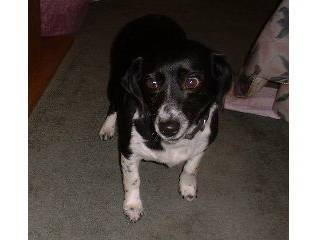

Prediction: dogs
Prediction detail: [[0.28358346 0.7164165 ]]


Nombre imagen: cat.3959.jpg


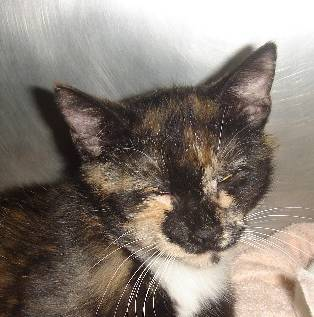

Prediction: cats
Prediction detail: [[0.5091478  0.49085212]]


Nombre imagen: dog.1278.jpg


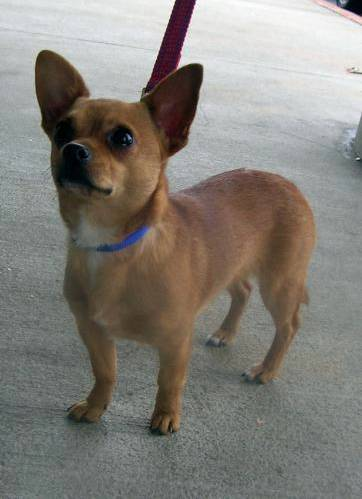

Prediction: dogs
Prediction detail: [[0.26000583 0.73999417]]


Nombre imagen: cat.1947.jpg


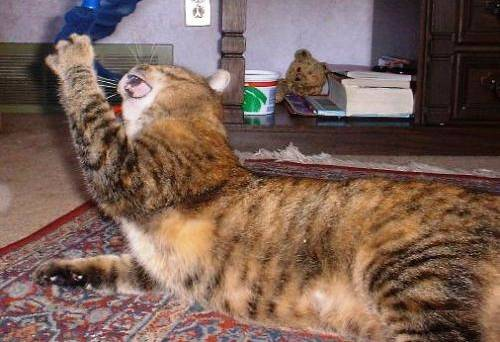

Prediction: cats
Prediction detail: [[0.6236986  0.37630144]]




In [137]:
predecir(2,model_mlp_1)

### MLP 2

In [126]:
# 2 capas densas con 30 neuronas
# 3 capas densas con 20 neuronas
# 3 capas densas con 10 neuronas
# Función de activación: Relu

model_mlp_2 = Sequential([
    
    Rescaling(1/255, input_shape=(64, 64, 3)), # normalizar las entradas de los datasets
  
    Dense(30, activation='relu'),
    Dropout(0.4),
    
    Flatten(),
    
    Dense(10, activation='relu'),

    
    Dense(10, activation='relu'),

    Dense(20, activation='relu'),
    Dropout(0.2),
    
    Dense(30, activation='relu'),
    
    Dense(20, activation='relu'),

    
    Dense(20, activation='relu'),
    
    Dense(10, activation='relu'),
    Dropout(0.2),
    
    Dense(len(animales), activation='softmax'),
    # salida de 2
])

model_mlp_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

In [177]:
model_mlp_2.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_24 (Rescaling)     (None, 64, 64, 3)         0         
_________________________________________________________________
dense_229 (Dense)            (None, 64, 64, 30)        120       
_________________________________________________________________
dropout_113 (Dropout)        (None, 64, 64, 30)        0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 122880)            0         
_________________________________________________________________
dense_230 (Dense)            (None, 10)                1228810   
_________________________________________________________________
dense_231 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_232 (Dense)            (None, 20)              

In [127]:
history_mlp_2 = model_mlp_2.fit(
    train,
    epochs=10,
    batch_size=50, # Ajusta los pesos cada x imagenes
    validation_data=test,
)

Epoch 1/10
251/251 [==============================] - 41s 160ms/step - loss: 0.6926 - accuracy: 0.5125 - val_loss: 0.6706 - val_accuracy: 0.5957
Epoch 2/10
251/251 [==============================] - 41s 163ms/step - loss: 0.6653 - accuracy: 0.6132 - val_loss: 0.6398 - val_accuracy: 0.6525
Epoch 3/10
251/251 [==============================] - 41s 161ms/step - loss: 0.6511 - accuracy: 0.6308 - val_loss: 0.6300 - val_accuracy: 0.6569
Epoch 4/10
251/251 [==============================] - 42s 166ms/step - loss: 0.6264 - accuracy: 0.6649 - val_loss: 0.6011 - val_accuracy: 0.6822
Epoch 5/10
251/251 [==============================] - 61s 241ms/step - loss: 0.5977 - accuracy: 0.6925 - val_loss: 0.6242 - val_accuracy: 0.6520
Epoch 6/10
251/251 [==============================] - 49s 194ms/step - loss: 0.5864 - accuracy: 0.6968 - val_loss: 0.5950 - val_accuracy: 0.6906
Epoch 7/10
251/251 [==============================] - 45s 177ms/step - loss: 0.5672 - accuracy: 0.7194 - val_loss: 0.5995 - val_ac

######################### train #########################
accuracy 0.7695190505933791


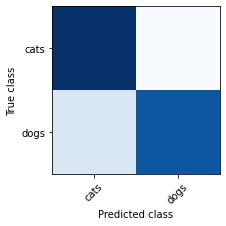

######################### test #########################
accuracy 0.69451309935739


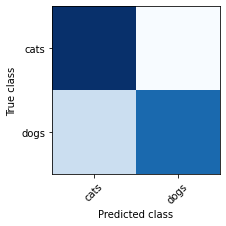

In [128]:
matriz(model_mlp_2)

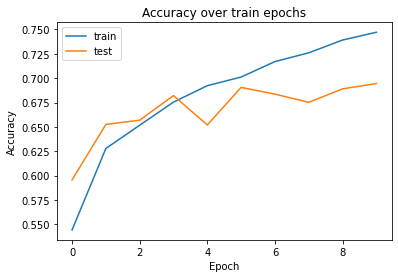

In [129]:
curvas(history_mlp_2)

## Conclusión MLP 2
Para el segundo modelo MLP podemos observar que obtuvimos mejores resultados con **76 %** de accuracy en **train** y un **69 %** en **test**.
Al igual que en el modelo anterior la **mayor cantidad de predicciones acertadas** es en la clase **gatos**.

Algunas predicciones:

Nombre imagen: dog.1324.jpg


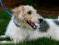

Prediction: dogs
Prediction detail: [[0.10744452 0.89255553]]


Nombre imagen: cat.2938.jpg


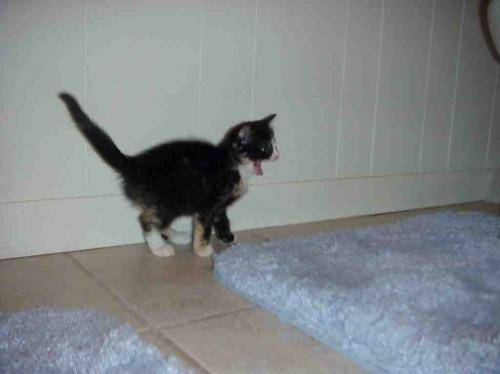

Prediction: dogs
Prediction detail: [[0.40024793 0.599752  ]]


Nombre imagen: dog.2267.jpg


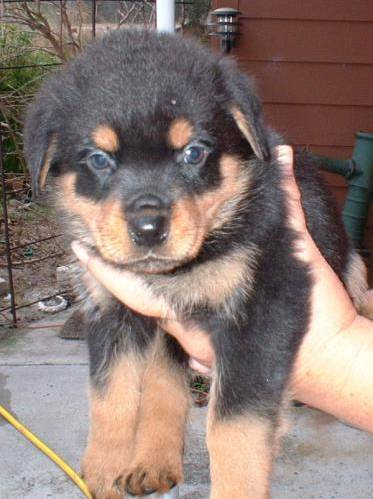

Prediction: dogs
Prediction detail: [[0.02848647 0.9715135 ]]


Nombre imagen: cat.2751.jpg


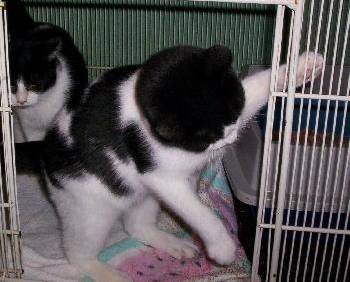

Prediction: cats
Prediction detail: [[0.9809672  0.01903272]]




In [138]:
predecir(2,model_mlp_2)

### CONVOLUCIONAL 1

In [87]:
# 2 capas de convolución con activación Relu
# 2 capas densas con 10 neuronas
# Función de activación: tanh

model_cnn1 = Sequential([

    Rescaling(1/255, input_shape=(64, 64, 3)), # normalizar las entradas de los datasets

    Convolution2D(filters=8, kernel_size=(4, 4), strides=1, activation='relu'),
    # kernels de 4x4x3, y salida de 61x61x8
    Dropout(0.2),
    
    Convolution2D(filters=8, kernel_size=(4, 4), strides=1, activation='relu'),
    # kernels de 4x4x8, y salida de 58x58x8
    Dropout(0.2),
    
    MaxPooling2D(pool_size=(4, 4)),
    # salida de 30x30x8
    
    Flatten(),
    # salida de 7200
    
    Dense(10, activation='tanh'),
    # salida de 10
    Dropout(0.2),
    
    Dense(10, activation='tanh'),
    # salida de 10
    Dropout(0.2),

    Dense(len(animales), activation='softmax'),
    # salida de 2
])

model_cnn1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [88]:
model_cnn1.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_10 (Rescaling)     (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 61, 61, 8)         392       
_________________________________________________________________
dropout_51 (Dropout)         (None, 61, 61, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 58, 8)         1032      
_________________________________________________________________
dropout_52 (Dropout)         (None, 58, 58, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 1568)            

In [89]:
history_cnn1 = model_cnn1.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=test,
)

Epoch 1/5
251/251 [==============================] - 72s 282ms/step - loss: 0.6899 - accuracy: 0.5353 - val_loss: 0.6557 - val_accuracy: 0.6223
Epoch 2/5
251/251 [==============================] - 67s 266ms/step - loss: 0.6348 - accuracy: 0.6445 - val_loss: 0.6288 - val_accuracy: 0.6421
Epoch 3/5
251/251 [==============================] - 95s 378ms/step - loss: 0.5805 - accuracy: 0.6933 - val_loss: 0.5927 - val_accuracy: 0.6822
Epoch 4/5
251/251 [==============================] - 88s 348ms/step - loss: 0.5508 - accuracy: 0.7266 - val_loss: 0.5571 - val_accuracy: 0.7153
Epoch 5/5
251/251 [==============================] - 74s 293ms/step - loss: 0.5364 - accuracy: 0.7362 - val_loss: 0.5727 - val_accuracy: 0.7128


######################### train #########################
accuracy 0.7494066208619613


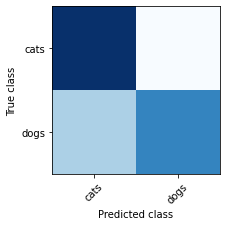

######################### test #########################
accuracy 0.71280276816609


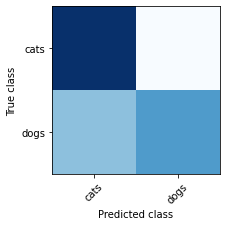

In [90]:
matriz(model_cnn1)

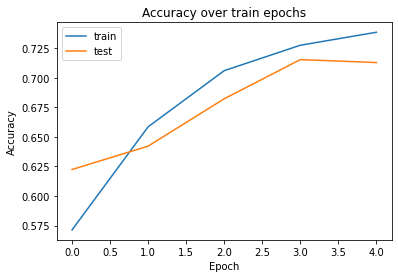

In [91]:
curvas(history_cnn1)

## Conclusión CNN 1
Para el primer modelo CNN podemos observar que obtuvimos **74 %** de accuracy en **train** y un **71 %** en **test**.

Algunas predicciones:

Nombre imagen: dog.3265.jpg


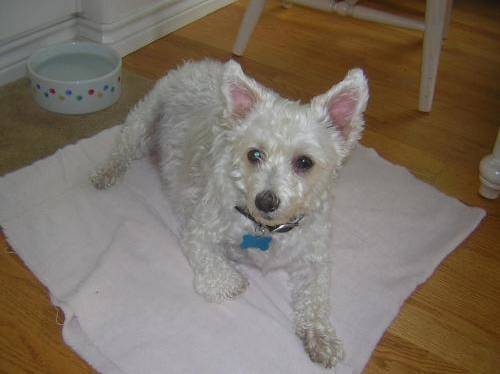

Prediction: cats
Prediction detail: [[0.7554221  0.24457794]]


Nombre imagen: cat.1261.jpg


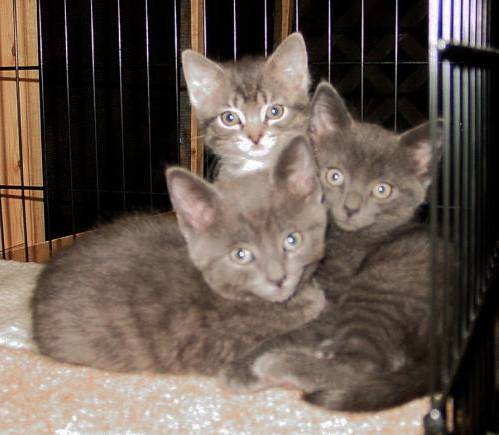

Prediction: cats
Prediction detail: [[0.9097161  0.09028387]]


Nombre imagen: dog.750.jpg


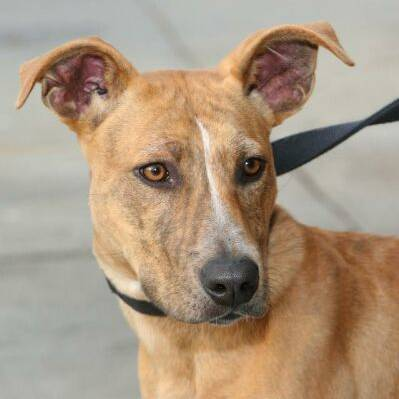

Prediction: dogs
Prediction detail: [[0.2928949 0.7071051]]


Nombre imagen: cat.387.jpg


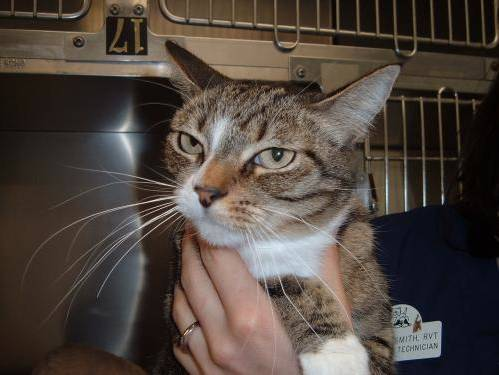

Prediction: dogs
Prediction detail: [[0.49462074 0.50537926]]




In [139]:
predecir(2,model_cnn1)

### CONVOLUCIONAL 2

In [93]:
# 2 capas de convolución con activación Relu y tanh
# 2 capas densas con 15 neuronas 
# Función de activación: Relu y tanh

model_cnn2 = Sequential([

    Rescaling(1/255, input_shape=(64, 64, 3)), # normalizar las entradas de los datasets

    Convolution2D(filters=8, kernel_size=(4, 4), strides=1, activation='tanh'),
    # kernels de 4x4x3, y salida de 61x61x8
    Dropout(0.1),
    
    Convolution2D(filters=8, kernel_size=(4, 4), strides=1, activation='relu'),
    # kernels de 4x4x8, y salida de 58x58x8
    Dropout(0.1),
    
    MaxPooling2D(pool_size=(4, 4)),
    # salida de 30x30x8
    
    Flatten(),
    # salida de 7200
    
    Dense(15, activation='relu'),
    # salida de 10
    Dropout(0.2),
    
    Dense(15, activation='tanh'),
    # salida de 10
    Dropout(0.2),

    Dense(len(animales), activation='softmax'),
    # salida de 2
])

model_cnn2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [94]:
model_cnn2.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_11 (Rescaling)     (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 8)         392       
_________________________________________________________________
dropout_55 (Dropout)         (None, 61, 61, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 8)         1032      
_________________________________________________________________
dropout_56 (Dropout)         (None, 58, 58, 8)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 1568)            

In [95]:
history_cnn2 = model_cnn2.fit(
    train,
    epochs=10,
    batch_size=128,
    validation_data=test,
)

Epoch 1/10
251/251 [==============================] - 70s 274ms/step - loss: 0.6943 - accuracy: 0.5258 - val_loss: 0.6471 - val_accuracy: 0.6436
Epoch 2/10
251/251 [==============================] - 67s 266ms/step - loss: 0.6387 - accuracy: 0.6444 - val_loss: 0.5986 - val_accuracy: 0.6826
Epoch 3/10
251/251 [==============================] - 68s 269ms/step - loss: 0.5815 - accuracy: 0.6970 - val_loss: 0.5614 - val_accuracy: 0.7168
Epoch 4/10
251/251 [==============================] - 68s 272ms/step - loss: 0.5276 - accuracy: 0.7419 - val_loss: 0.5597 - val_accuracy: 0.7242
Epoch 5/10
251/251 [==============================] - 68s 270ms/step - loss: 0.5014 - accuracy: 0.7620 - val_loss: 0.5447 - val_accuracy: 0.7276
Epoch 6/10
251/251 [==============================] - 69s 275ms/step - loss: 0.5093 - accuracy: 0.7607 - val_loss: 0.5502 - val_accuracy: 0.7395
Epoch 7/10
251/251 [==============================] - 70s 276ms/step - loss: 0.4523 - accuracy: 0.7890 - val_loss: 0.5604 - val_ac

######################### train #########################
accuracy 0.8423485321673954


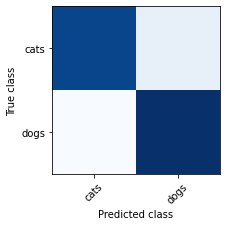

######################### test #########################
accuracy 0.7305981216015818


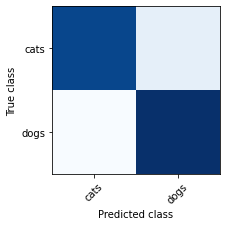

In [96]:
matriz(model_cnn2)

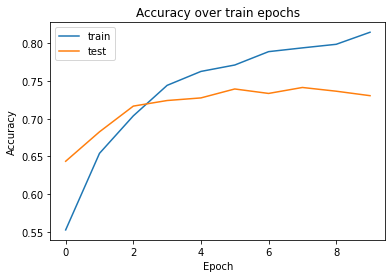

In [97]:
curvas(history_cnn2)

## Conclusión CNN 2
Para el segundo modelo CNN podemos observar que obtuvimos **84 %** de accuracy en **train** y un **73 %** en **test**.

Algunas predicciones:

Nombre imagen: dog.172.jpg


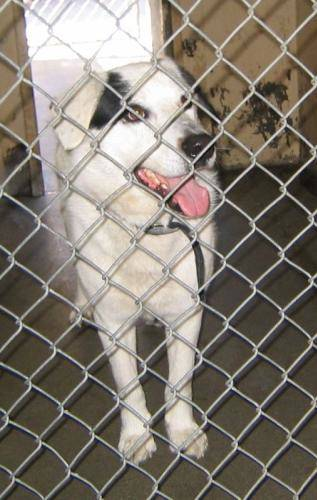

Prediction: dogs
Prediction detail: [[0.00851665 0.9914833 ]]


Nombre imagen: cat.724.jpg


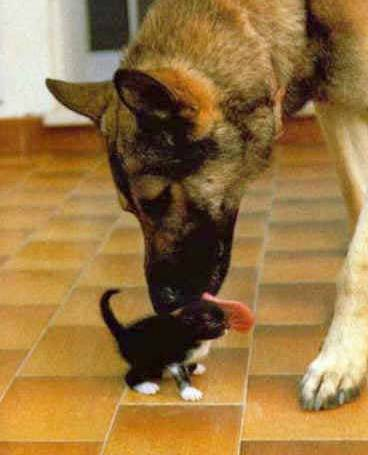

Prediction: cats
Prediction detail: [[0.51617956 0.48382044]]


Nombre imagen: dog.3780.jpg


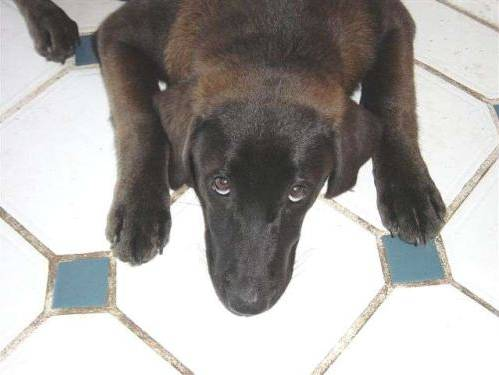

Prediction: dogs
Prediction detail: [[0.402742 0.597258]]


Nombre imagen: cat.1437.jpg


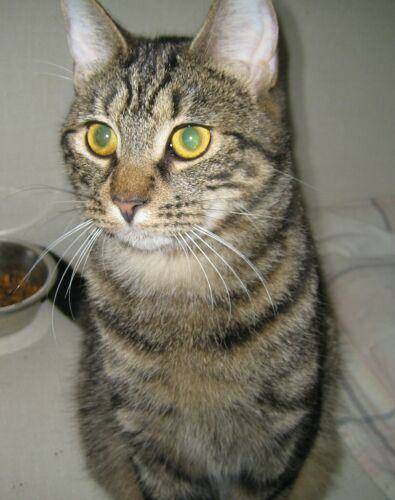

Prediction: cats
Prediction detail: [[0.5450402  0.45495975]]




In [140]:
predecir(2,model_cnn2)

## CONCLUSIÓN FINAL

### MLP 
El mejor modelo que construimos de MLP es el **model_mlp_2**


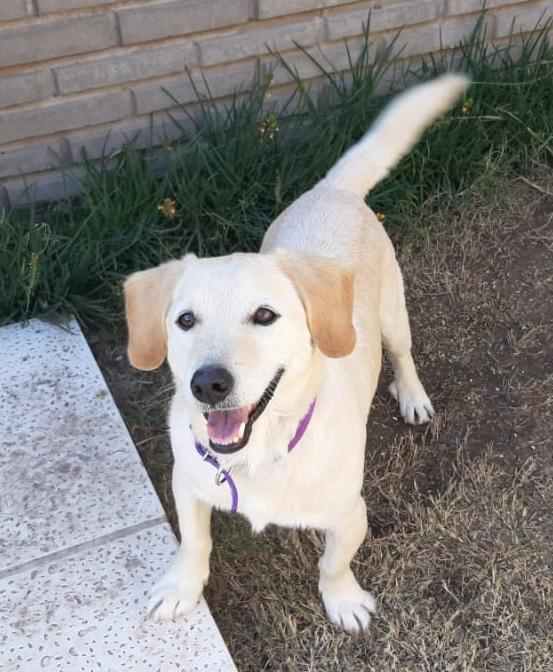

Prediction: cats
Prediction detail: [[0.73922586 0.26077417]]


In [141]:
show_and_predict(model_mlp_2,"./Fotos/beto.jpg")

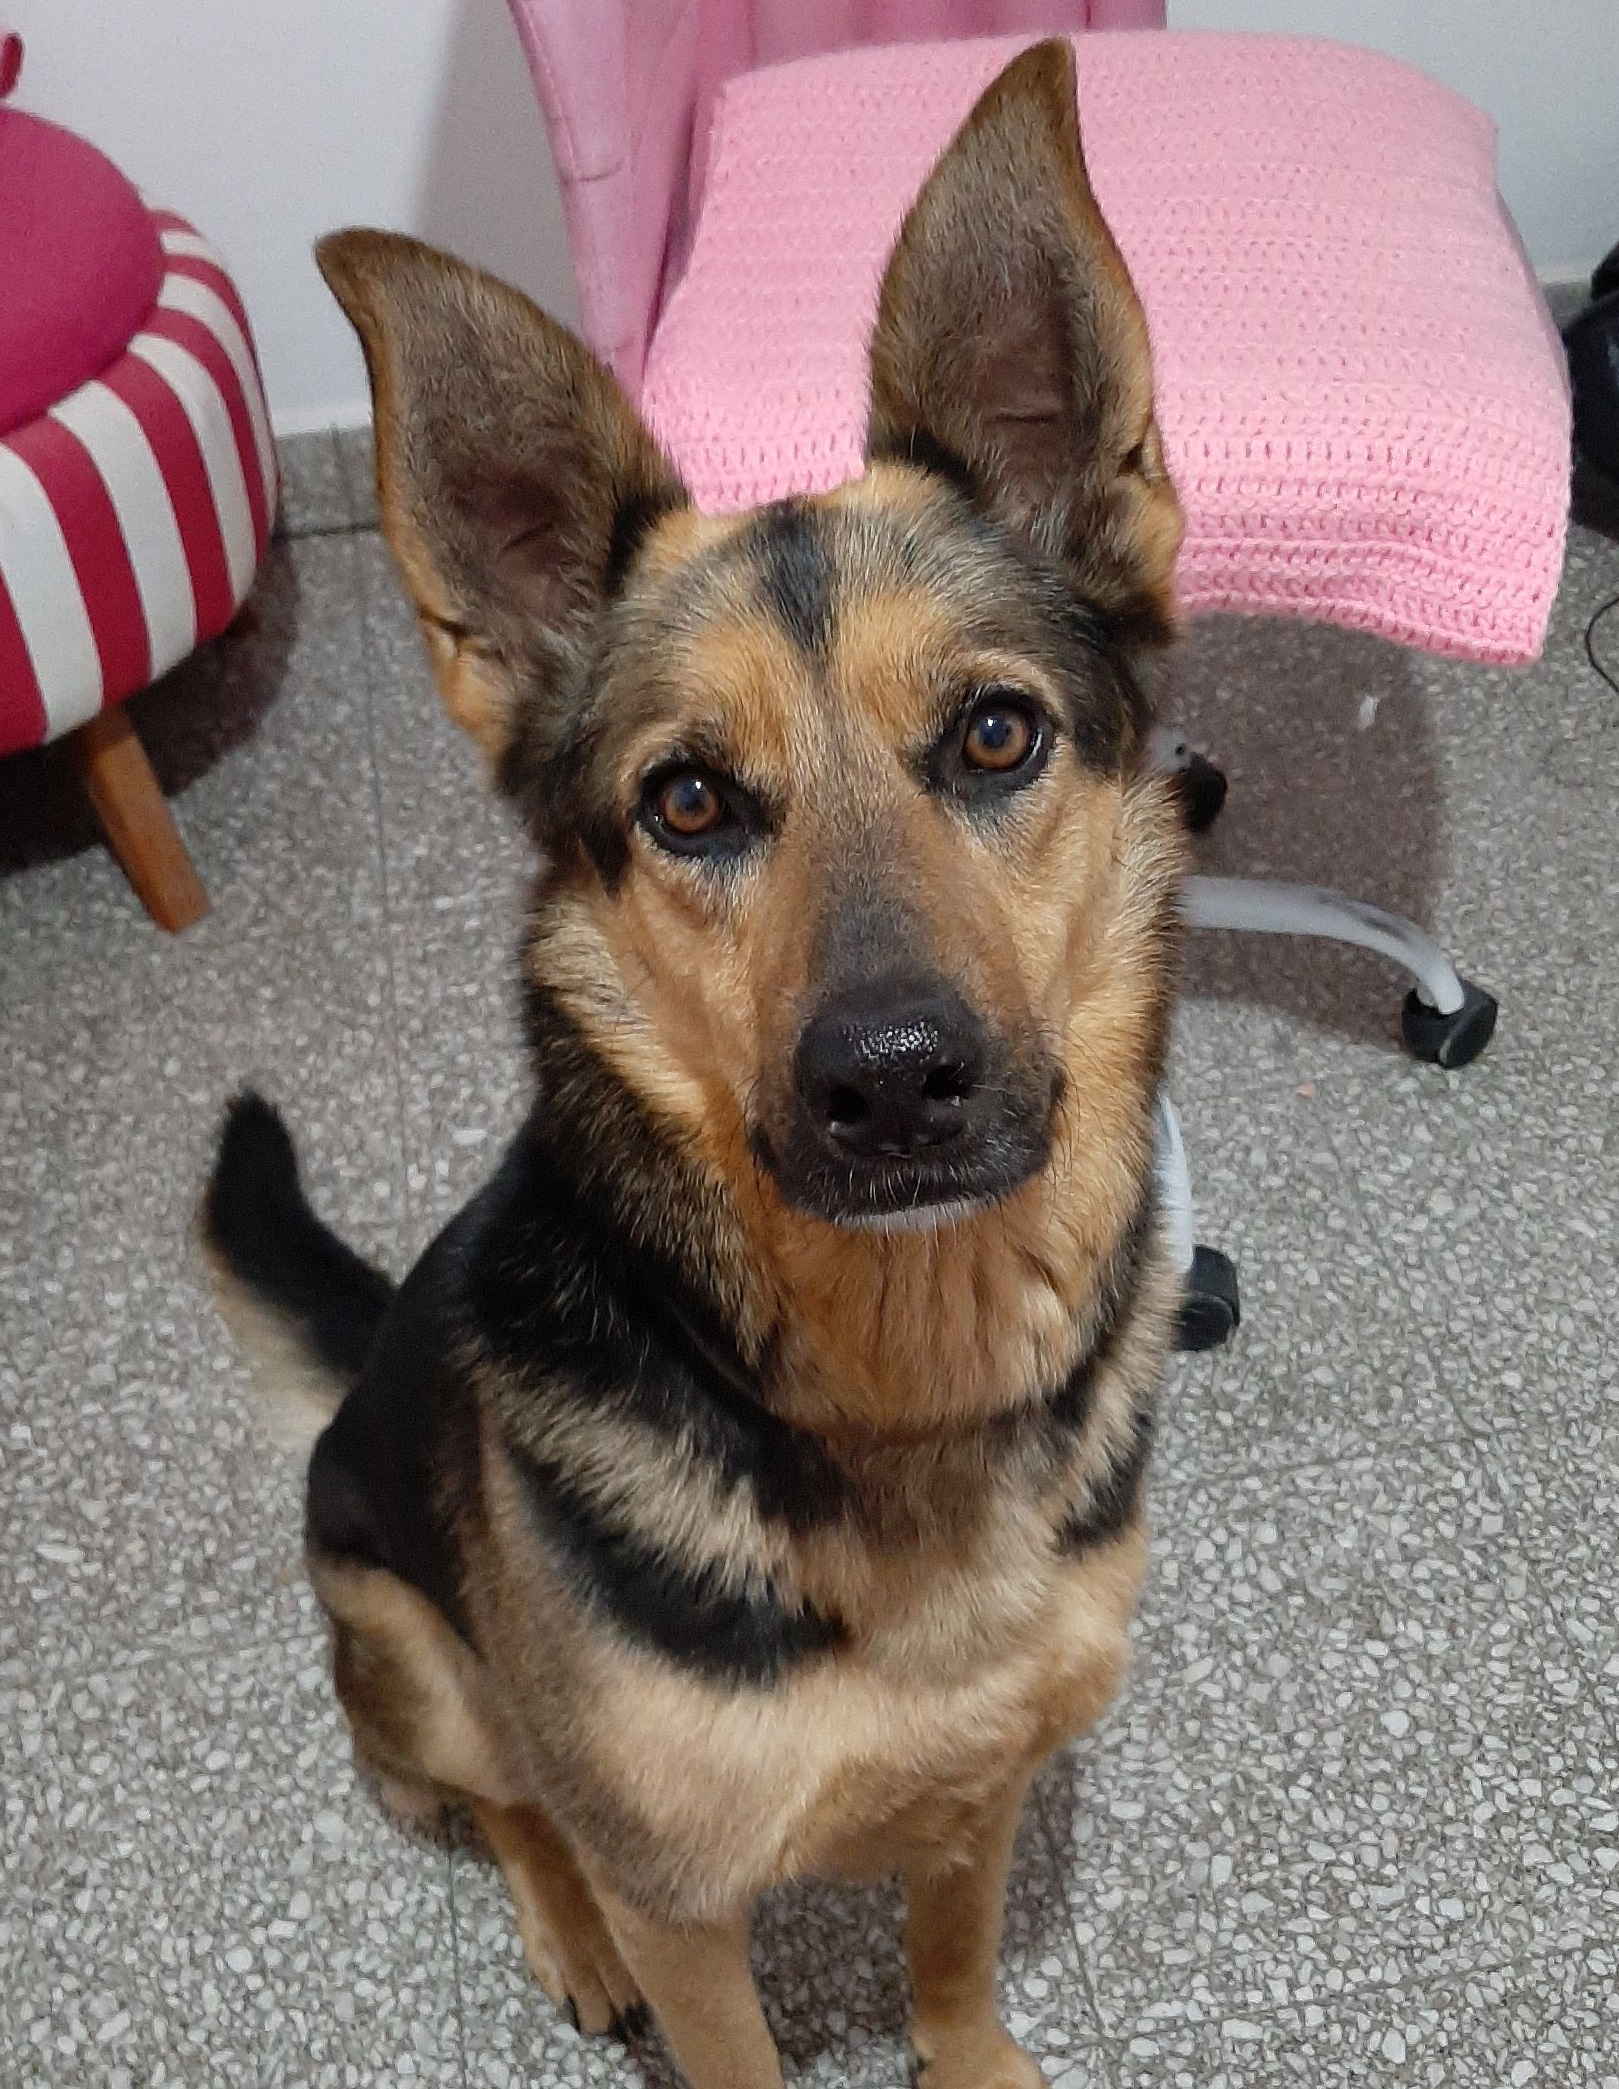

Prediction: dogs
Prediction detail: [[0.13245212 0.8675478 ]]


In [145]:
show_and_predict(model_mlp_2,"./Fotos/oli1.jpeg")

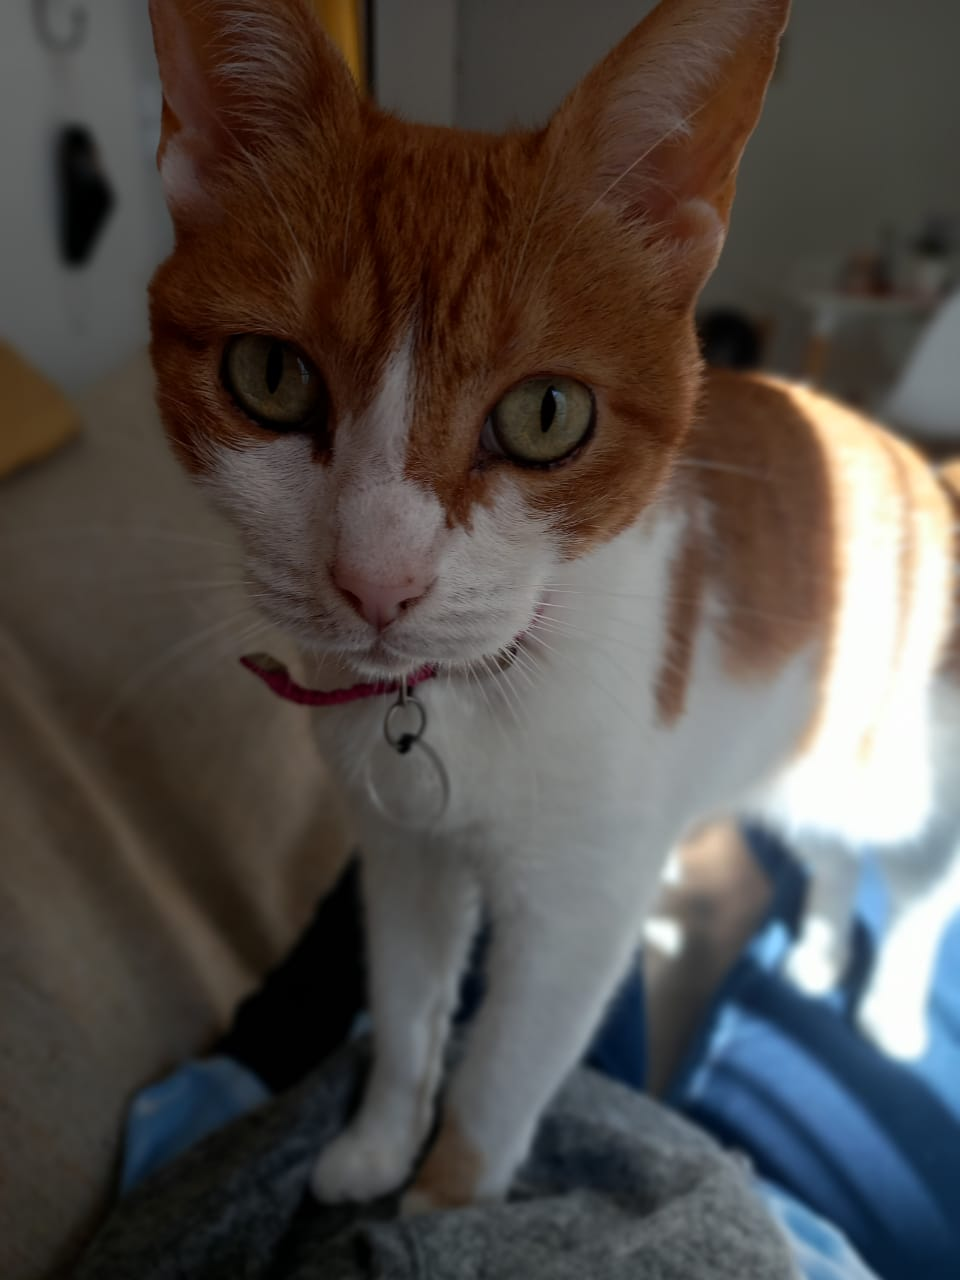

Prediction: dogs
Prediction detail: [[0.48286435 0.5171357 ]]


In [152]:
show_and_predict(model_mlp_2,"./Fotos/venus1.jpg")

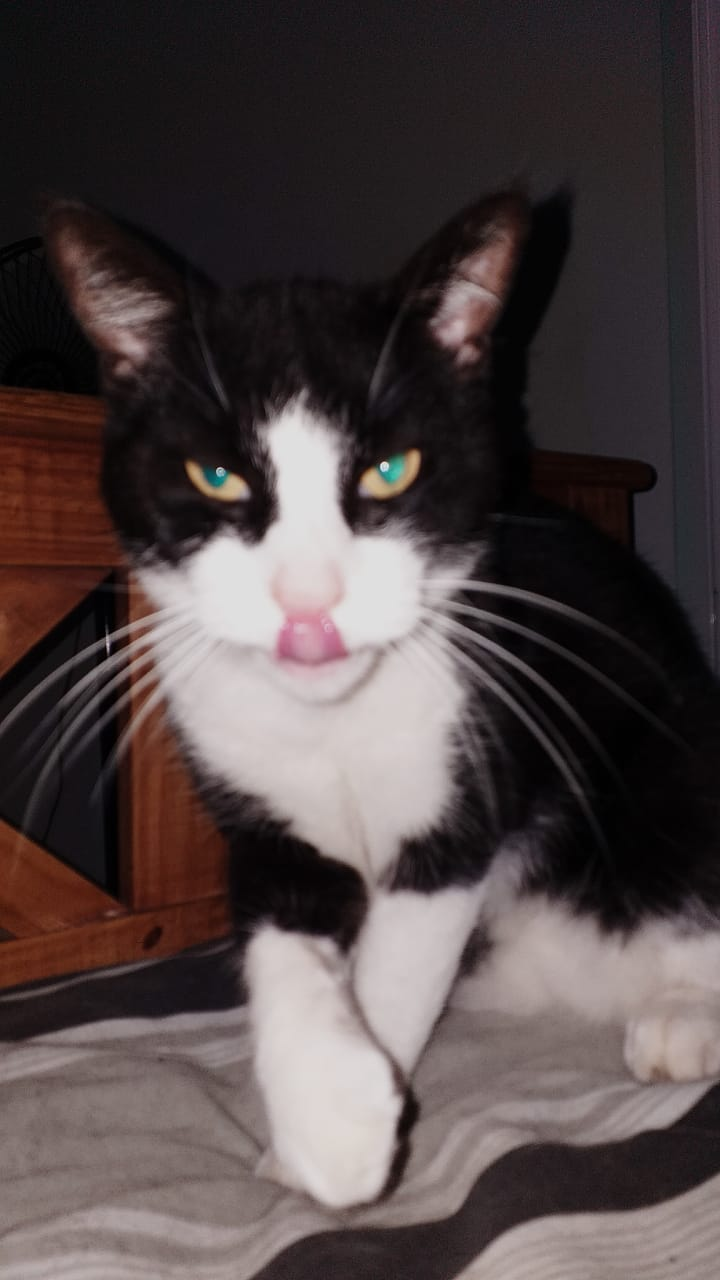

Prediction: cats
Prediction detail: [[0.9505485  0.04945146]]


In [154]:
show_and_predict(model_mlp_2,"./Fotos/negro.jpeg")

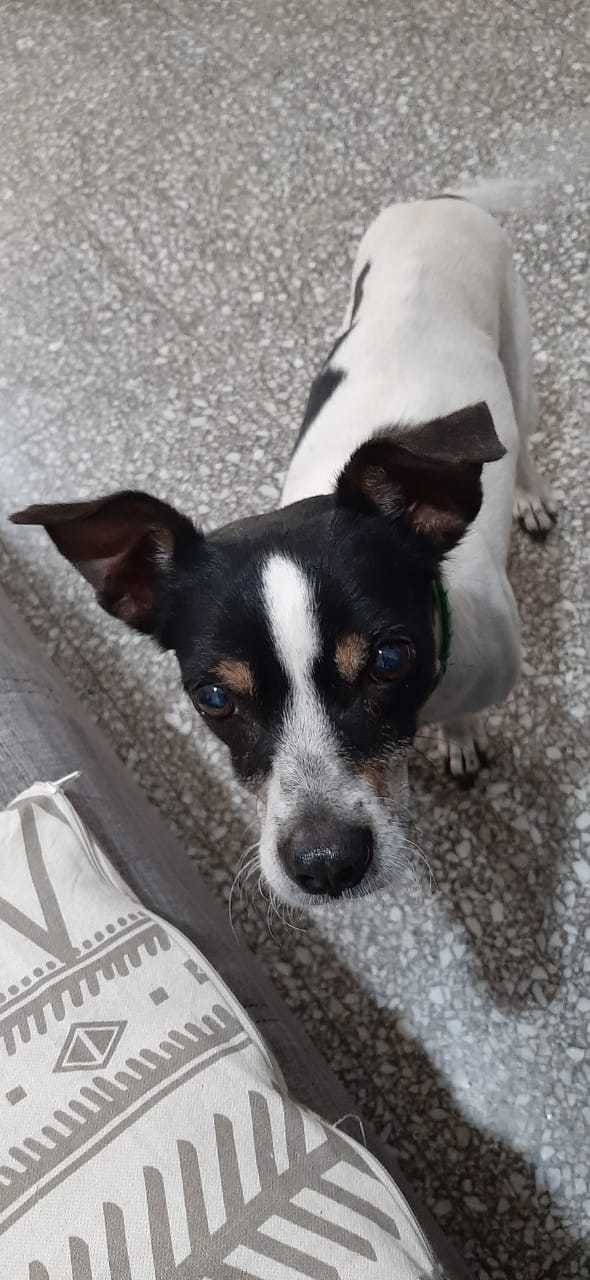

Prediction: dogs
Prediction detail: [[0.07619744 0.9238026 ]]


In [148]:
show_and_predict(model_mlp_2,"./Fotos/toto1.jpeg")

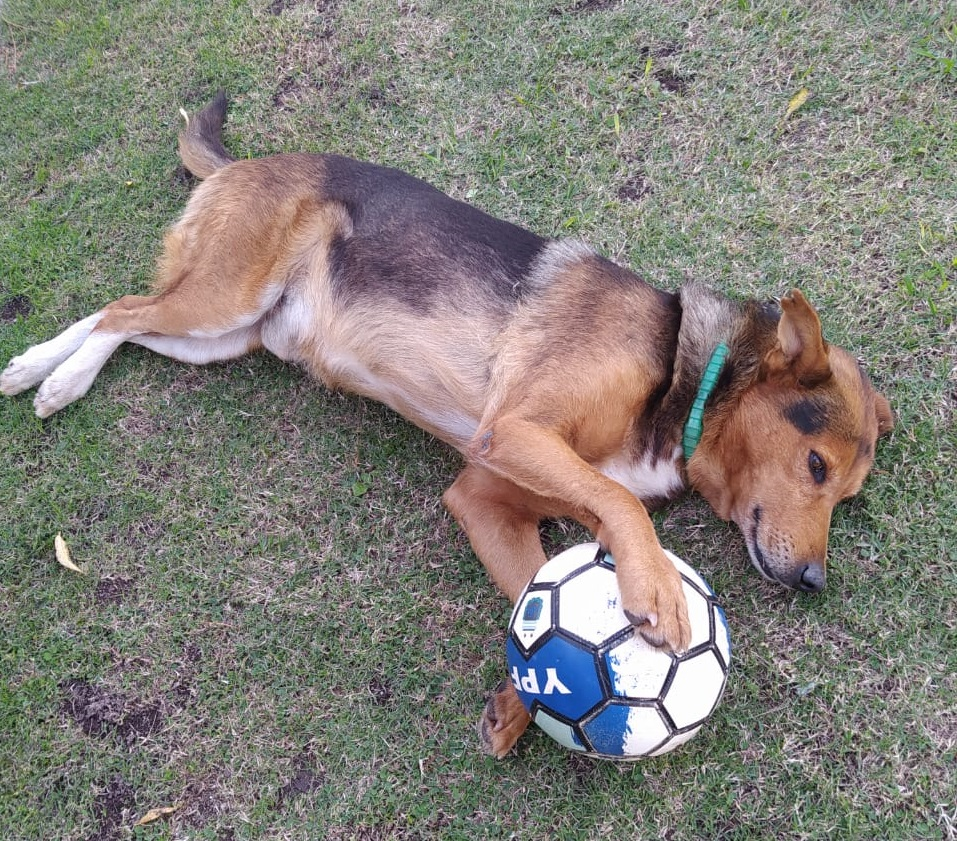

Prediction: dogs
Prediction detail: [[0.12440353 0.87559646]]


In [149]:
show_and_predict(model_mlp_2,"./Fotos/cacho.jpg")

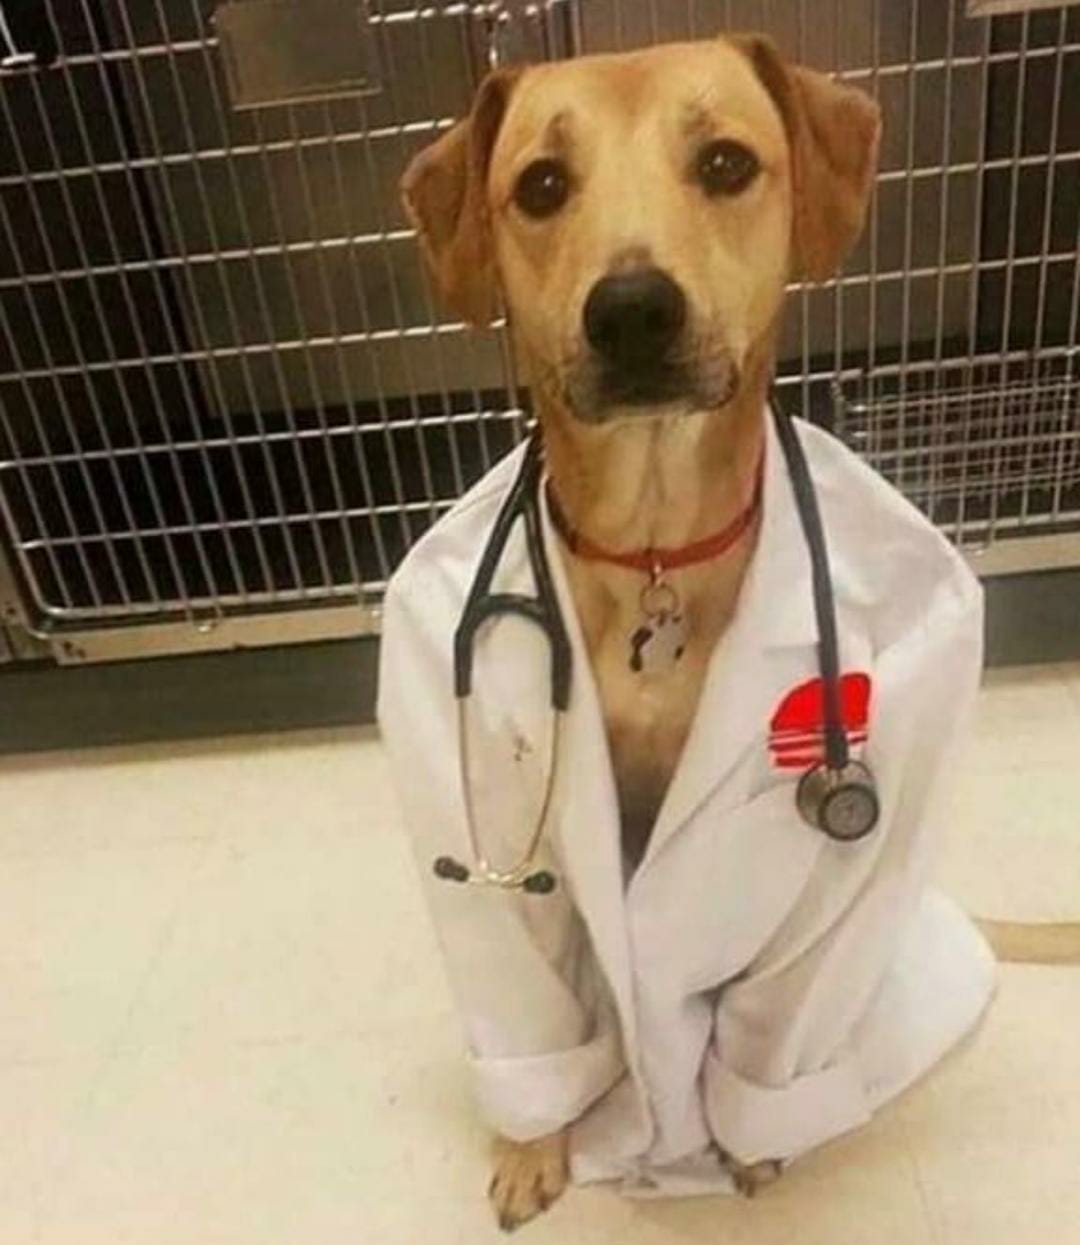

Prediction: dogs
Prediction detail: [[9.539752e-04 9.990460e-01]]


In [151]:
show_and_predict(model_mlp_2,"./Fotos/dogtor.jpeg")

### CNN
El mejor modelo que constuimos de CNN es el model_cnn2

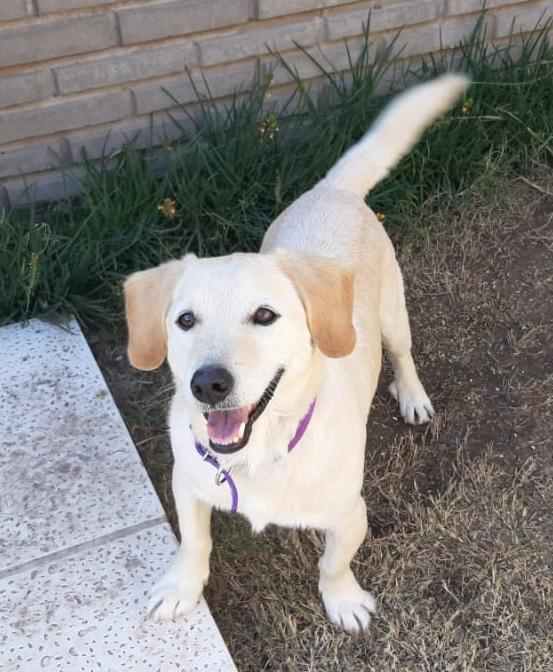

Prediction: dogs
Prediction detail: [[0.03779344 0.96220654]]


In [155]:
show_and_predict(model_cnn2,"./Fotos/beto.jpg")

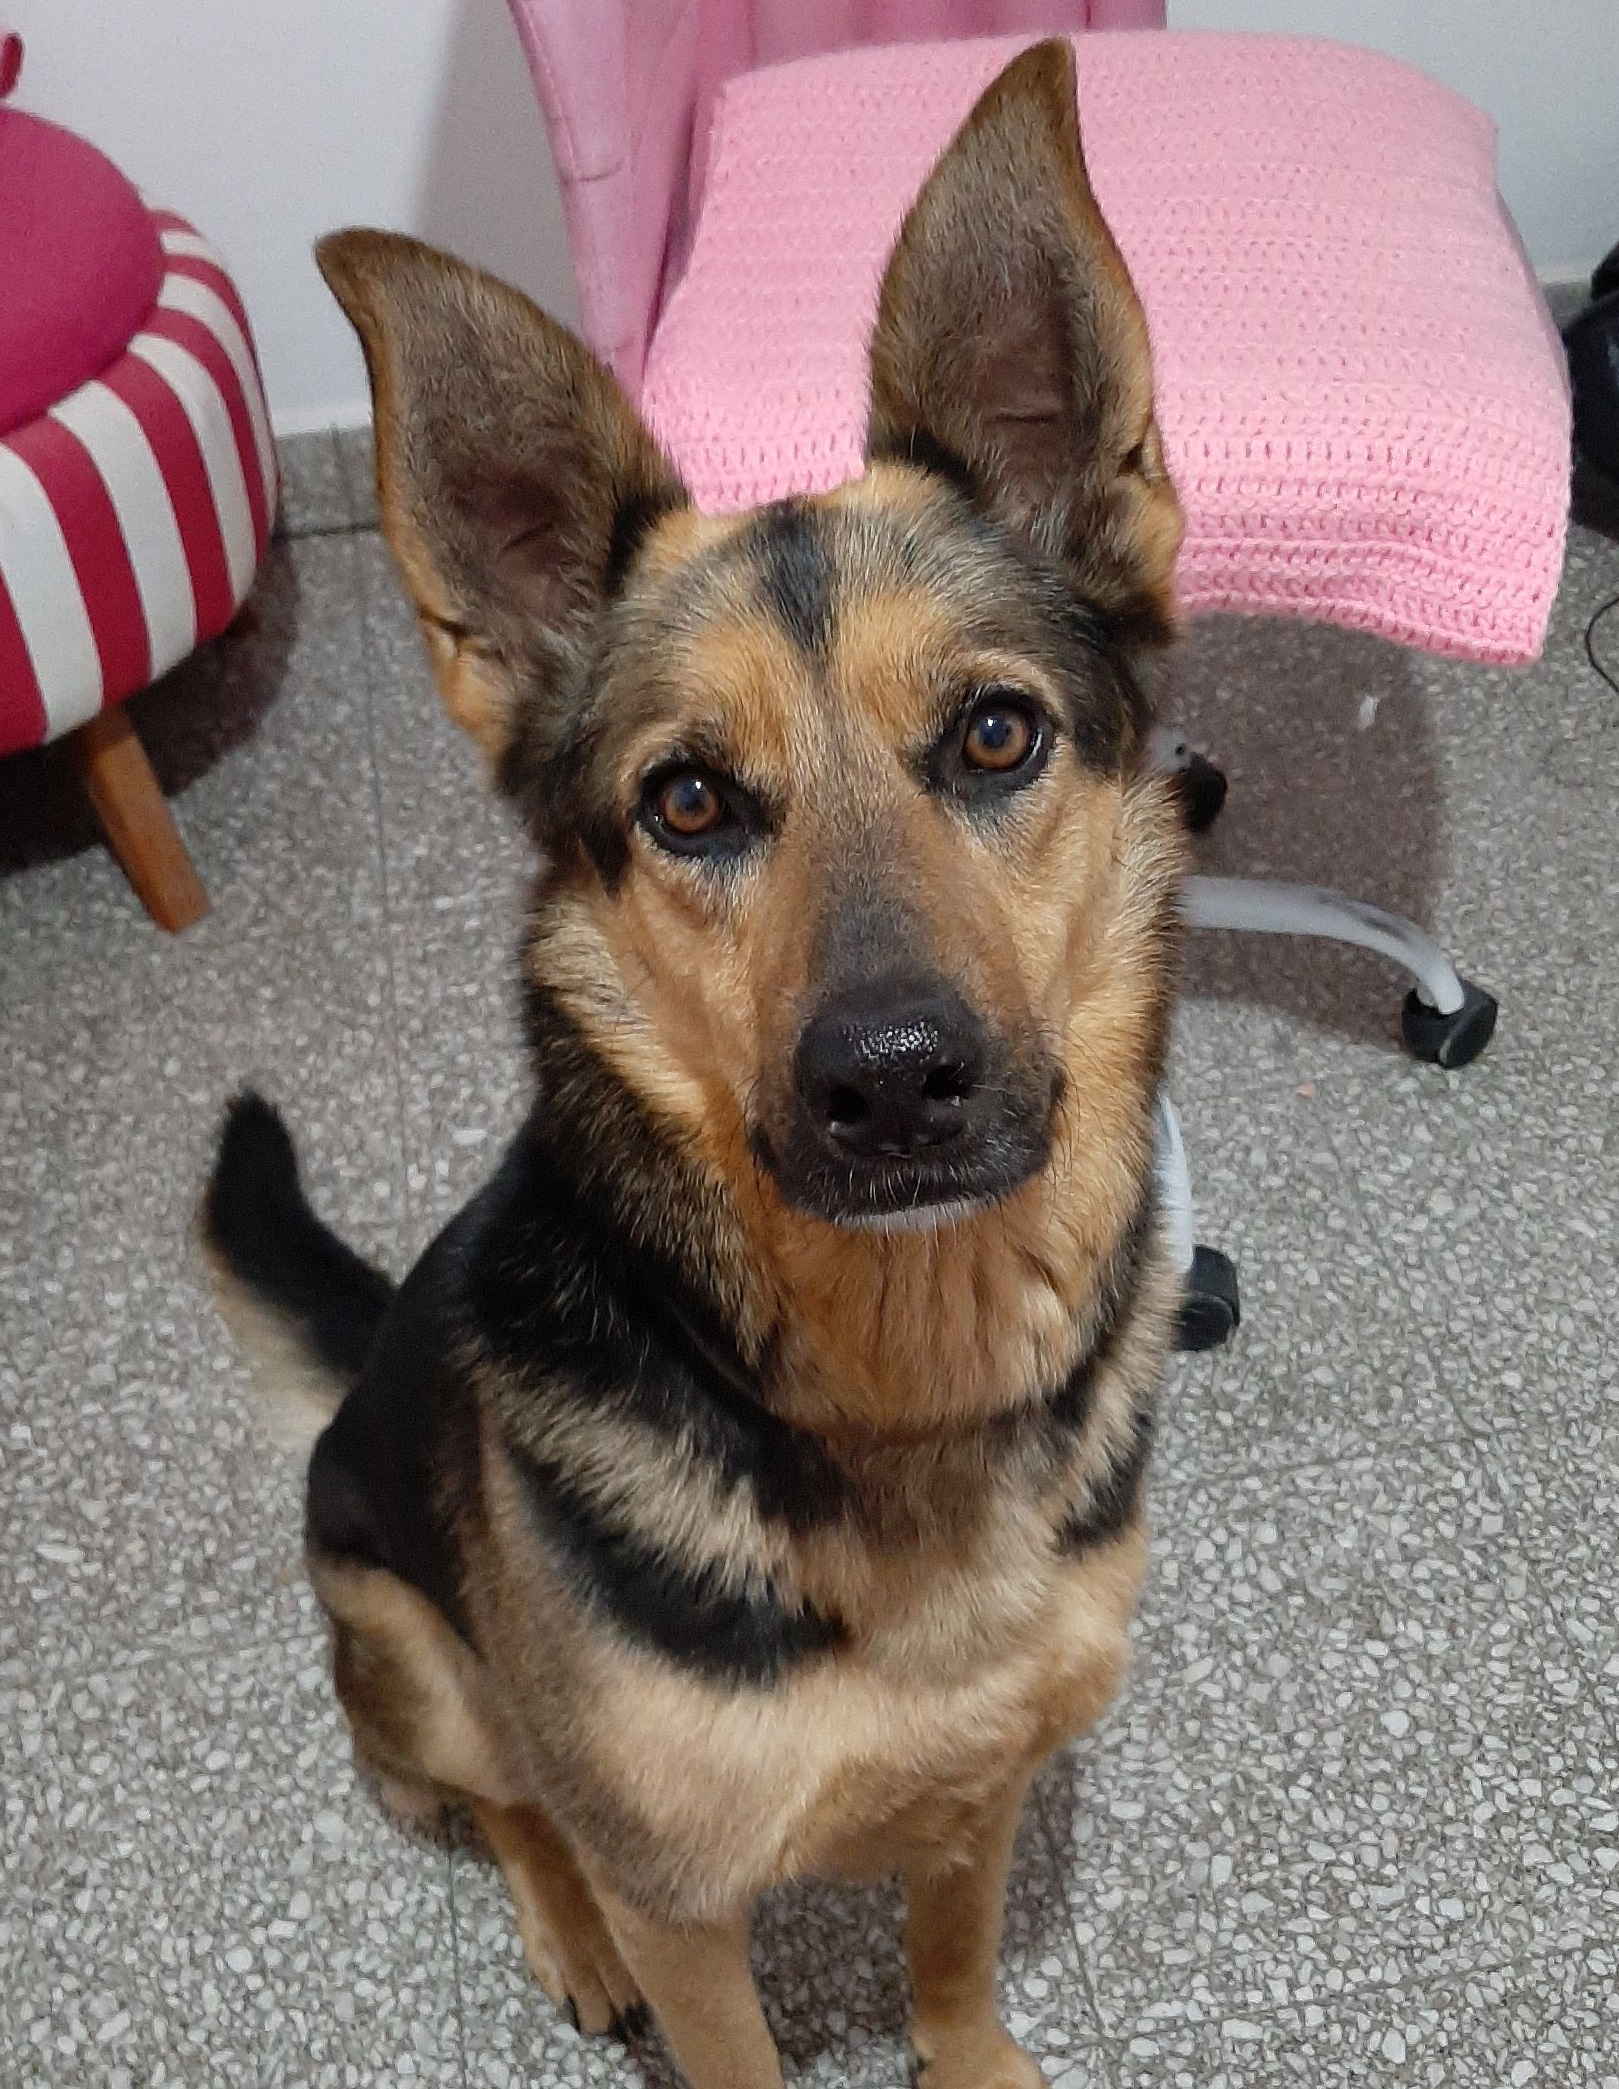

Prediction: dogs
Prediction detail: [[0.3933675 0.6066325]]


In [156]:
show_and_predict(model_cnn2,"./Fotos/oli1.jpeg")

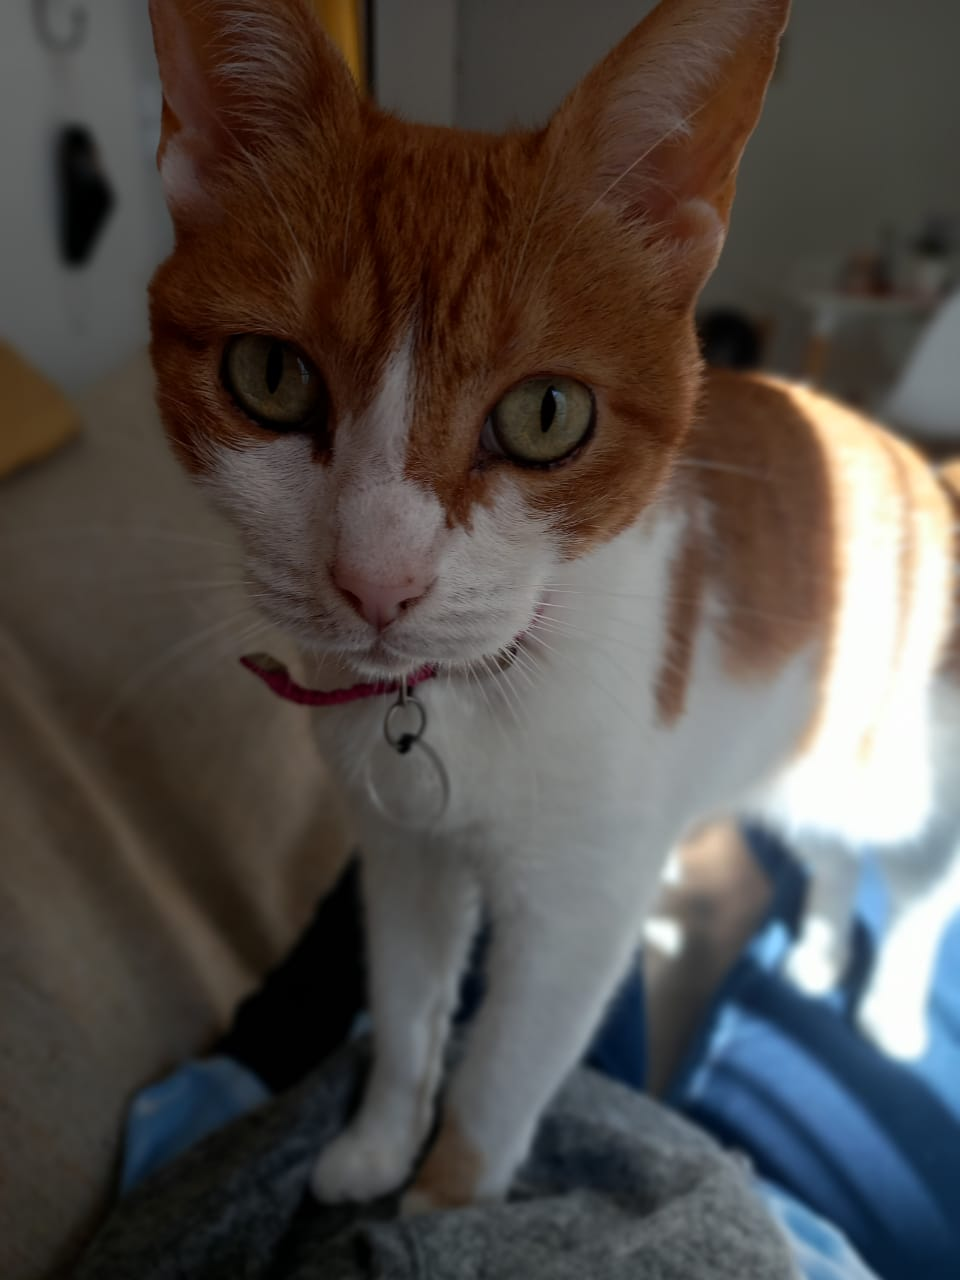

Prediction: cats
Prediction detail: [[0.8896668  0.11033321]]


In [158]:
show_and_predict(model_cnn2,"./Fotos/venus1.jpg")

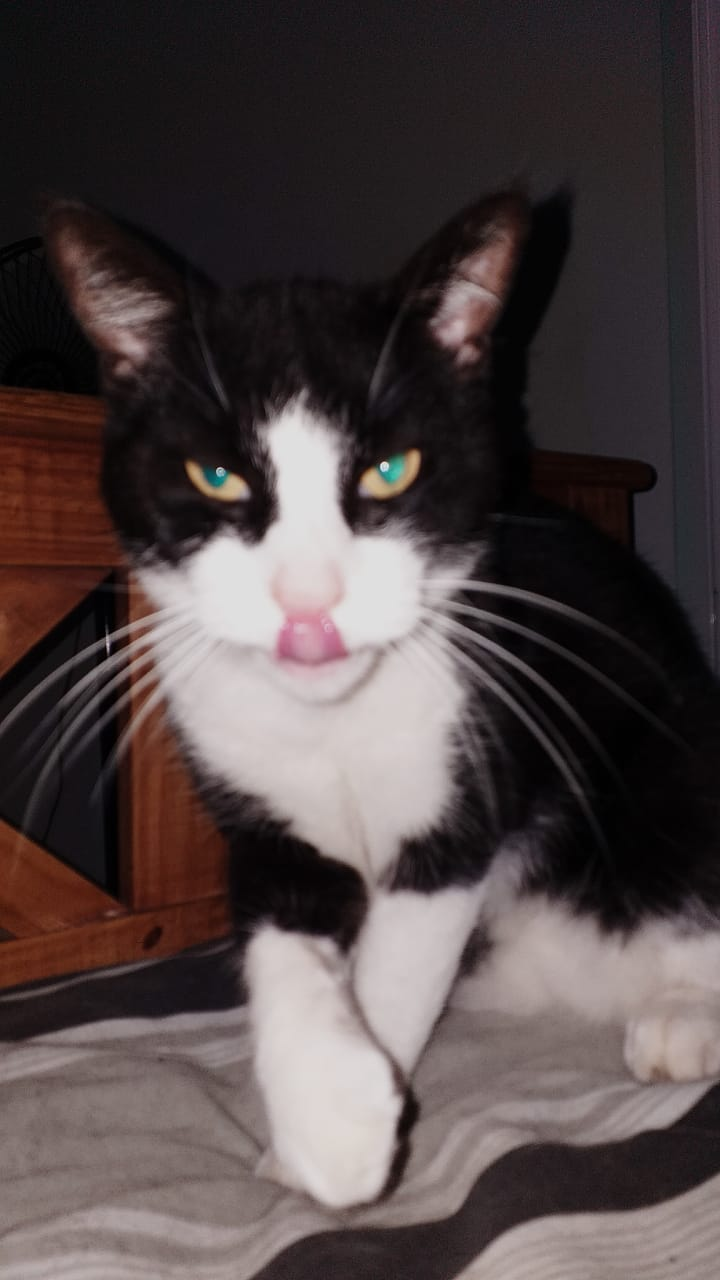

Prediction: cats
Prediction detail: [[0.87778676 0.12221324]]


In [159]:
show_and_predict(model_cnn2,"./Fotos/negro.jpeg")

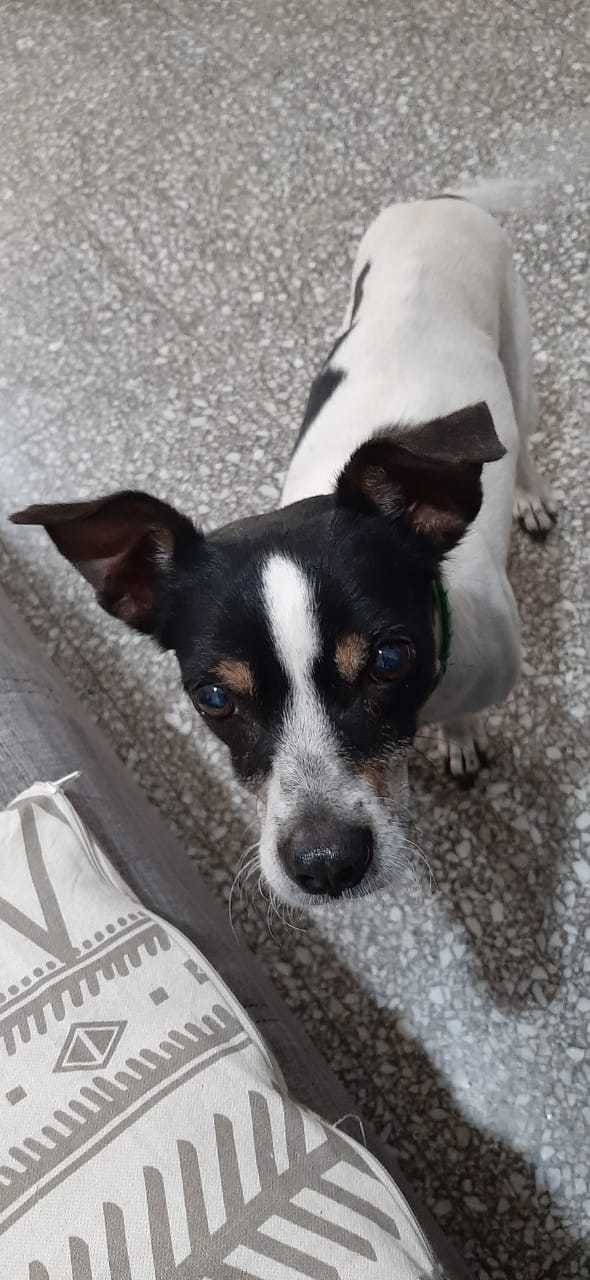

Prediction: dogs
Prediction detail: [[0.1756503 0.8243497]]


In [160]:
show_and_predict(model_cnn2,"./Fotos/toto1.jpeg")

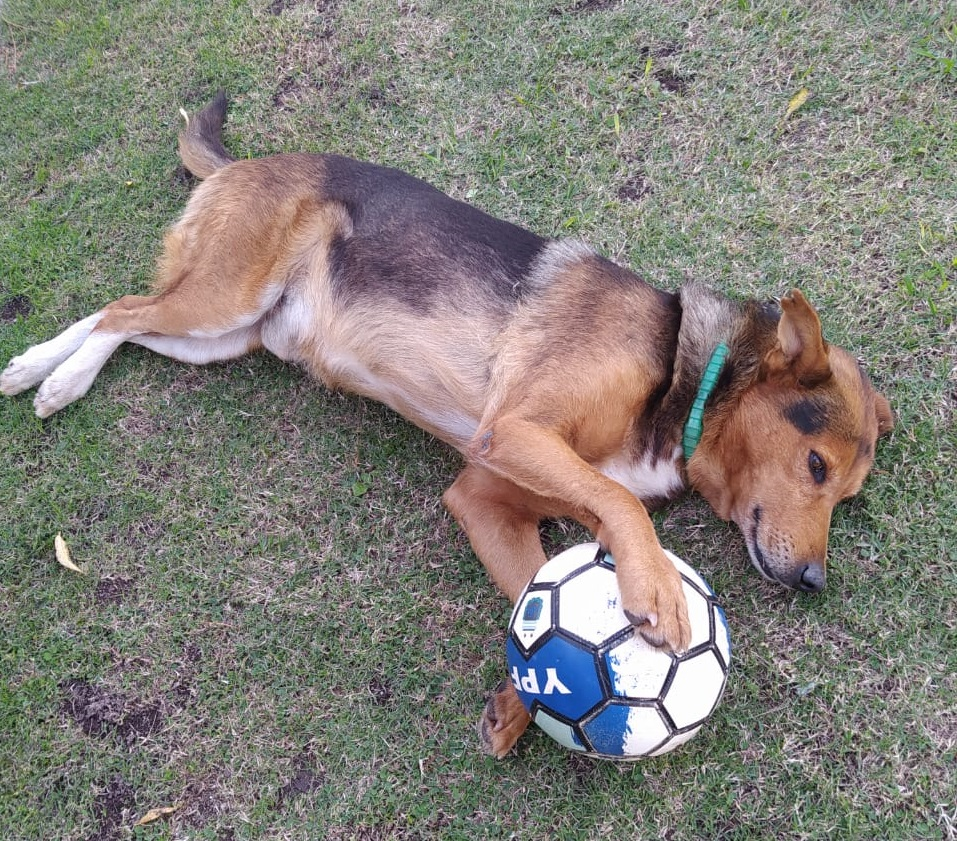

Prediction: dogs
Prediction detail: [[0.01050199 0.989498  ]]


In [162]:
show_and_predict(model_cnn2,"./Fotos/cacho.jpg")

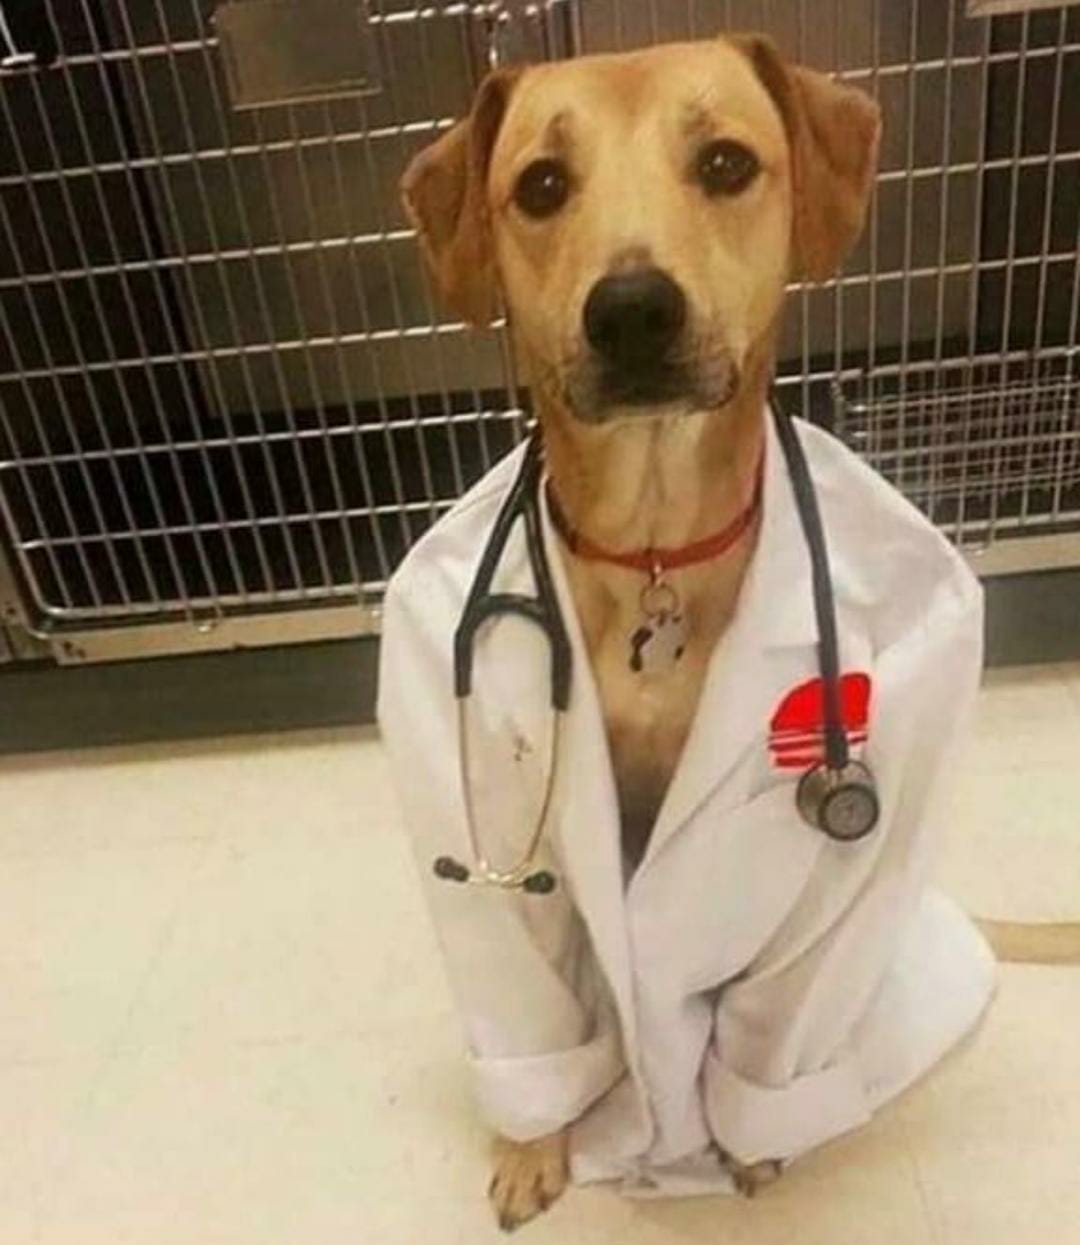

Prediction: cats
Prediction detail: [[0.5344789  0.46552107]]


In [173]:
show_and_predict(model_cnn2,"./Fotos/dogtor.jpeg")

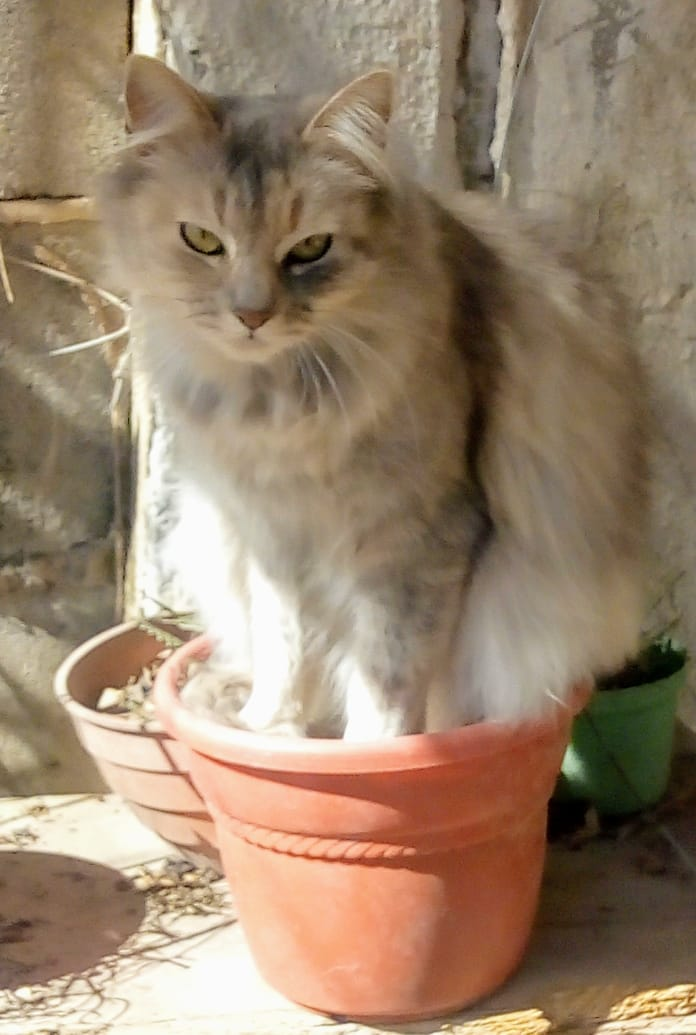

Prediction: dogs
Prediction detail: [[0.16438128 0.8356188 ]]


In [167]:
show_and_predict(model_cnn2,"./Fotos/nina.jpeg")

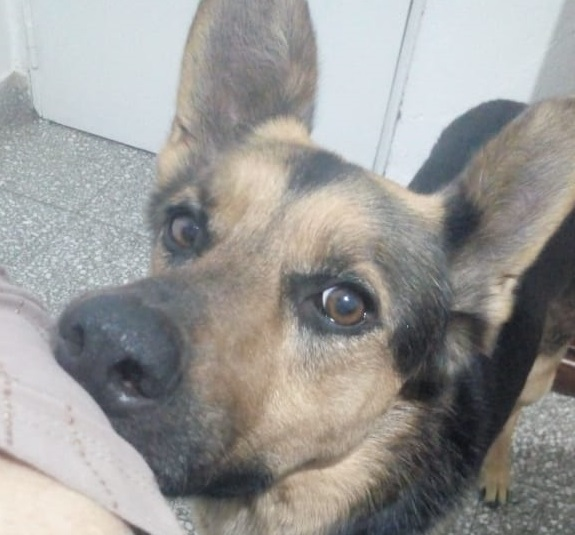

Prediction: cats
Prediction detail: [[0.98581797 0.01418206]]


In [169]:
show_and_predict(model_cnn2,"./Fotos/oli4.jpg")

## Posibles mejoras

- Entrenar los modelos con mas épocas y/o probar con otras combinaciones de capas y neuronas.
- Utilizar clases como ImageDataGenerator para alterar las imagenes aplicandole zoom o rotandolas en el dataset de train.